In [39]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Add project root


In [40]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from torchvision import transforms as T
from torch.utils.data import DataLoader

from src.dataset import ChestXrayDataset
from src.model import get_model

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)



Device: mps


In [41]:
# Transform and Validation loader

val_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

val_dataset = ChestXrayDataset(
    csv_file="../data/processed/val_small.csv",
    image_dir="../data/images",
    transform=val_transform
)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
print("Validation samples:", len(val_dataset))


Validation samples: 5000


In [42]:
# Load best model

model = get_model().to(device)
model.load_state_dict(torch.load("../results/best_model.pt", map_location=device))
model.eval()
print("Model loaded")



Model loaded


In [43]:
# Run inference 

all_labels = []
all_probs = []
all_images = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs).squeeze(1)
        probs = torch.sigmoid(outputs)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_images.extend(imgs.cpu())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print("Min prob:", all_probs.min())
print("Max prob:", all_probs.max())
print("Mean prob:", all_probs.mean())



100%|█████████████████████████████████████████| 313/313 [00:54<00:00,  5.71it/s]

Min prob: 0.4221413
Max prob: 0.9544
Mean prob: 0.5135321


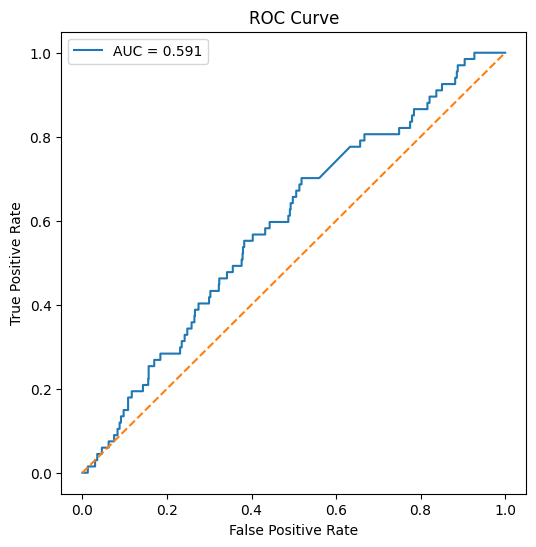

In [44]:
# ROC CURVE

fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [75]:
# Confusion matrix

preds = (all_probs > 0.5).astype(int)
cm = confusion_matrix(all_labels, preds)
tn, fp, fn, tp = cm.ravel()

print("TP:", tp)
print("FN:", fn)
print("TN:", tn)
print("FP:", fp)

cm


TP: 54
FN: 13
TN: 1429
FP: 3504


array([[1429, 3504],
       [  13,   54]])

In [30]:
# Build TP / FN / TN DataFrames

results_df = pd.DataFrame({
    "label": all_labels,
    "pred": preds,
    "prob": all_probs
})

tp_df = results_df[(results_df.label == 1) & (results_df.pred == 1)]
fn_df = results_df[(results_df.label == 1) & (results_df.pred == 0)]
tn_df = results_df[(results_df.label == 0) & (results_df.pred == 0)]
fp_df = results_df[(results_df.label == 0) & (results_df.pred == 1)]

print("TP:", len(tp_df))
print("FN:", len(fn_df))
print("TN:", len(tn_df))
print("FP:", len(fp_df))



TP: 54
FN: 13
TN: 1429
FP: 3504


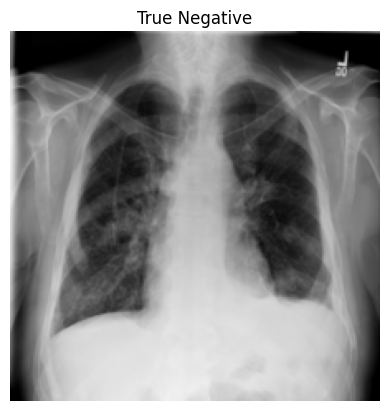

In [31]:
# Show example images

def show_img(tensor, title):
    img = tensor.permute(1,2,0)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

if len(tp_df) > 0:
    idx = tp_df.index[0]
    show_img(all_images[idx], "True Positive")

if len(fn_df) > 0:
    idx = fn_df.index[0]
    show_img(all_images[idx], "False Negative")

if len(tn_df) > 0:
    idx = tn_df.index[0]
    show_img(all_images[idx], "True Negative")


In [32]:
# Save example images

import os
os.makedirs("../results/examples", exist_ok=True)

def save_img(tensor, name):
    img = tensor.permute(1,2,0).numpy()
    plt.imsave(f"../results/examples/{name}.png", img)

if len(tp_df) > 0:
    save_img(all_images[tp_df.index[0]], "true_positive")

if len(fn_df) > 0:
    save_img(all_images[fn_df.index[0]], "false_negative")

if len(tn_df) > 0:
    save_img(all_images[tn_df.index[0]], "true_negative")

print("Saved example images")


Saved example images


In [33]:
# Import gradcam

import cv2
from src.gradcam import GradCAM


In [34]:
# Pick a target layer (RESNET)

target_layer = model.layer4[-1]

gradcam = GradCAM(model, target_layer)
print("GradCAM ready")


GradCAM ready


In [35]:
# Select an image (False Negative is most interesting)

# Prefer False Negative (missed pneumonia)
if len(fn_df) > 0:
    idx = fn_df.index[0]
    title = "False Negative"
elif len(tp_df) > 0:
    idx = tp_df.index[0]
    title = "True Positive"
else:
    idx = tn_df.index[0]
    title = "True Negative"

input_tensor = all_images[idx].unsqueeze(0).to(device)
original_img = all_images[idx]

print("Using:", title)


Using: False Negative


In [36]:
# Generate Grad-CAM

cam = gradcam.generate(input_tensor)

cam = cam[0]
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
cam = cv2.resize(cam, (224,224))


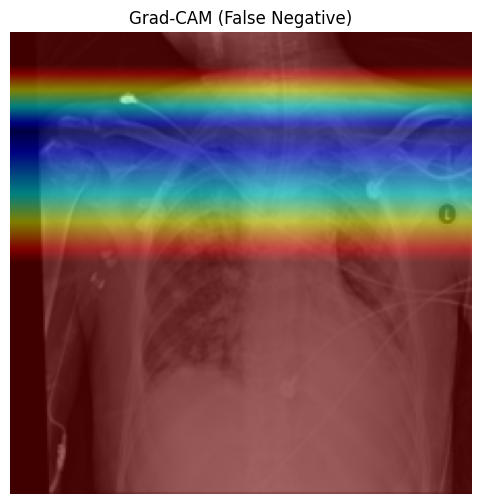

In [37]:
# Overlay heatmap

img_np = original_img.permute(1,2,0).numpy()

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

overlay = 0.5 * heatmap + 0.5 * img_np

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title(f"Grad-CAM ({title})")
plt.axis("off")
plt.show()


In [38]:
# Save Grad-CAM image

os.makedirs("../results/gradcam", exist_ok=True)
plt.imsave(f"../results/gradcam/{title.lower().replace(' ','_')}_gradcam.png", overlay)
print("Saved Grad-CAM image")


Saved Grad-CAM image
